In [46]:
# %matplotlib widget

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import itertools

In [48]:
df = pd.read_pickle('pickles/295-roles.pkl')

[None, None]

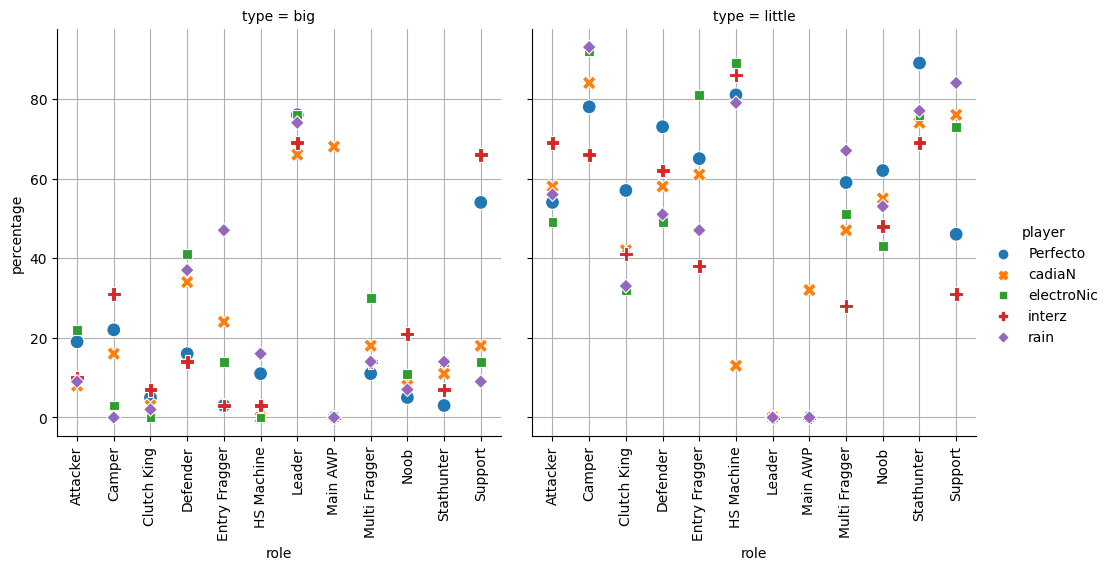

In [49]:
# scatter

# need to melt big and little for sns relplot
dfm = df.melt(id_vars=['role', 'player'], value_vars=['big', 'little'], var_name='type', value_name='percentage')

axgrid = sns.relplot(
    data=dfm, x='role', y='percentage',
    col='type',
    hue="player", style="player",
    kind="scatter",
    s=100,
    zorder=5
)

[ax.tick_params(axis='x', rotation=90) for ax in axgrid.axes.ravel()]
[ax.grid(zorder=1, which='major') for ax in axgrid.axes.ravel()]

<AxesSubplot:xlabel='None-player', ylabel='role'>

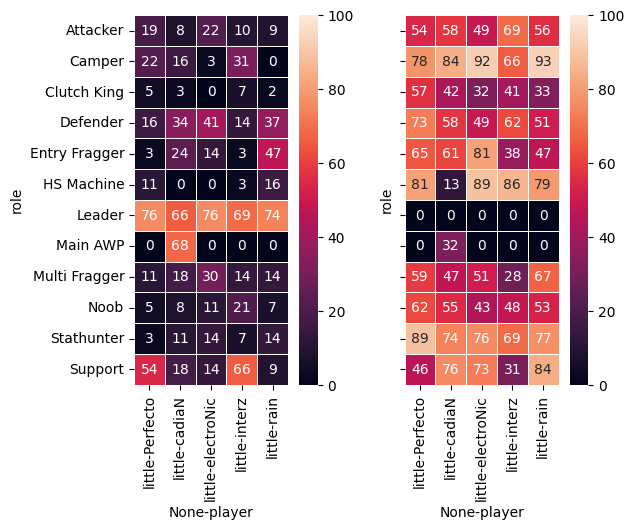

In [50]:
# heatmap

fig, axs = plt.subplots(1,2, sharex=True, sharey=True)

sns.heatmap(
    data=df.pivot(index=['role'], columns=['player'], values=['big']),
    linewidths=.5,
    annot=True, square=True,
    # cbar=False,
    vmin=0, vmax=100,
    ax=axs[0]
)

sns.heatmap(
    data=df.pivot(index=['role'], columns=['player'], values=['little']),
    linewidths=.5,
    annot=True, square=True,
    # cbar=False,
    vmin=0, vmax=100,
    ax=axs[1]
)

In [51]:
def lazy_top5(df, by):
    picks = pd.DataFrame(columns=df.columns)

    for _ in range(5):
        tmp = df[df.apply(lambda x: x['player'] not in list(picks['player']) and x['role'] not in list(picks['role']), axis=1)].sort_values(by=by, ascending=False).iloc[0]
        picks = pd.concat([picks, tmp.to_frame().T])
    
    return picks


picks = lazy_top5(df, 'big')
display(picks)
print(f"{picks['big'].sum()=}, {picks['little'].sum()=}")

picks = lazy_top5(df, 'little')
display(picks)
print(f"{picks['big'].sum()=}, {picks['little'].sum()=}")


,role,player,big,little
30,Leader,electroNic,76,0
19,Main AWP,cadiaN,68,32
47,Support,interz,66,31
52,Entry Fragger,rain,47,47
1,Camper,Perfecto,22,78


picks['big'].sum()=279, picks['little'].sum()=188


,role,player,big,little
49,Camper,rain,0,93
29,HS Machine,electroNic,0,89
10,Stathunter,Perfecto,3,89
23,Support,cadiaN,18,76
36,Attacker,interz,10,69


picks['big'].sum()=31, picks['little'].sum()=416


In [52]:
def maybe_smarter_top5(df, by):
    # First collect all name / role combinations that can make sense.
    # Keep looking for another role for a player, if at least one more 
    # player has that role as maximum role also.

    df_role_per_name = df.groupby('player', group_keys=True).apply(lambda x: x[['role', 'big', 'little']].sort_values(by=by, ascending=False))

    names = df['player'].unique()
    spots = len(names)
    roles = df['role'].unique()

    options_dict = {}
    roleidx = 0
    for roleidx in range(len(roles)):
        for name in names:
            # x = df_role_per_name.loc[name].iloc[roleidx]
            index_in_df = df_role_per_name.loc[name].index[roleidx]
            role = df.iloc[index_in_df]['role']
            # raise SystemExit((f'{role.iloc[0]=}'))
            # raise SystemExit(f'{df.iloc[index_in_df]=}')
            # role = x['role']
            # percentage = x[by]
            try:
                options_dict[role]['indices'].append(index_in_df)
                options_dict[role]['role_needs_another_pass'] = True
            except KeyError:
                options_dict[role] = {'indices': [index_in_df], 'role_needs_another_pass': False}

        names = []

        for role, roledata in options_dict.items():
            if roledata['role_needs_another_pass']:# and len(options_dict[role]['names']) > 1:
                # print(f'{role=} needs another pass')
                # raise SystemExit(f'{[x for x in df["player"].iloc[roledata["indices"]]]}')
                names = df["player"].iloc[roledata["indices"]]
            options_dict[role]['role_needs_another_pass'] = False

        if len(names) == 0:
            break

    flatten_indices = [index for x in options_dict.values() for index in x['indices']]

    # Generate all 5 pick options, then filter out proper ones.
    comps = itertools.combinations(flatten_indices, r=5)
    def filter_comps(comps):
        for comp in comps:
            if len(df.iloc[list(comp)]['player'].unique()) == spots and len(df.iloc[list(comp)]['role'].unique()) == spots:
                yield comp
    filtered_comps = filter_comps(comps)

    # Find maximum sum.
    def sum_comp(comp):
        return df.iloc[list(comp)][by].sum()
    picked_comp = max(filtered_comps, key=lambda x: sum_comp(x))
    
    return picked_comp

picked_comp = maybe_smarter_top5(df, 'big')
display(df.iloc[list(picked_comp)])
print(f'{df.iloc[list(picked_comp)]["big"].sum()=} {df.iloc[list(picked_comp)]["little"].sum()=}')

picked_comp = maybe_smarter_top5(df, 'little')
display(df.iloc[list(picked_comp)])
print(f'{df.iloc[list(picked_comp)]["big"].sum()=} {df.iloc[list(picked_comp)]["little"].sum()=}')


,role,player,big,little
6,Leader,Perfecto,76,0
19,Main AWP,cadiaN,68,32
47,Support,interz,66,31
27,Defender,electroNic,41,49
52,Entry Fragger,rain,47,47


df.iloc[list(picked_comp)]["big"].sum()=298 df.iloc[list(picked_comp)]["little"].sum()=159


,role,player,big,little
10,Stathunter,Perfecto,3,89
25,Camper,electroNic,3,92
41,HS Machine,interz,3,86
23,Support,cadiaN,18,76
56,Multi Fragger,rain,14,67


df.iloc[list(picked_comp)]["big"].sum()=41 df.iloc[list(picked_comp)]["little"].sum()=410


In [53]:
df

,role,player,big,little
0,Attacker,Perfecto,19,54
1,Camper,Perfecto,22,78
2,Clutch King,Perfecto,5,57
3,Defender,Perfecto,16,73
4,Entry Fragger,Perfecto,3,65
5,HS Machine,Perfecto,11,81
6,Leader,Perfecto,76,0
7,Main AWP,Perfecto,0,0
8,Multi Fragger,Perfecto,11,59
9,Noob,Perfecto,5,62


In [54]:
df.groupby('player', group_keys=True).apply(lambda x: x[['role', 'big', 'little']].sort_values(by='big', ascending=False))

role  big  little
player                                   
Perfecto   6          Leader   76       0
           11        Support   54      46
           1          Camper   22      78
           0        Attacker   19      54
           3        Defender   16      73
           5      HS Machine   11      81
           8   Multi Fragger   11      59
           2     Clutch King    5      57
           9            Noob    5      62
           4   Entry Fragger    3      65
           10     Stathunter    3      89
           7        Main AWP    0       0
cadiaN     19       Main AWP   68      32
           18         Leader   66       0
           15       Defender   34      58
           16  Entry Fragger   24      61
           20  Multi Fragger   18      47
           23        Support   18      76
           13         Camper   16      84
           22     Stathunter   11      74
           12       Attacker    8      58
           21           Noob    8      55
           14    Clutch King    3      42
           17     HS Machine    0      13
electroNic 30         Leader   76       0
           27       Defender   41      49
           32  Multi Fragger   30      51
           24       Attacker   22      49
           28  Entry Fragger   14      81
           34     Stathunter   14      76
           35        Support   14      73
           33           Noob   11      43
           25         Camper    3      92
           26    Clutch King    0      32
           29     HS Machine    0      89
           31       Main AWP    0       0
interz     42         Leader   69       0
           47        Support   66      31
           37         Camper   31      66
           45           Noob   21      48
           39       Defender   14      62
           44  Multi Fragger   14      28
           36       Attacker   10      69
           38    Clutch King    7      41
           46     Stathunter    7      69
           40  Entry Fragger    3      38
           41     HS Machine    3      86
           43       Main AWP    0       0
rain       54         Leader   74       0
           52  Entry Fragger   47      47
           51       Defender   37      51
           53     HS Machine   16      79
           56  Multi Fragger   14      67
           58     Stathunter   14      77
           48       Attacker    9      56
           59        Support    9      84
           57           Noob    7      53
           50    Clutch King    2      33
           49         Camper    0      93
           55       Main AWP    0       0

In [55]:
df.sort_values(by='big', ascending=False)

,role,player,big,little
30,Leader,electroNic,76,0
6,Leader,Perfecto,76,0
54,Leader,rain,74,0
42,Leader,interz,69,0
19,Main AWP,cadiaN,68,32
47,Support,interz,66,31
18,Leader,cadiaN,66,0
11,Support,Perfecto,54,46
52,Entry Fragger,rain,47,47
27,Defender,electroNic,41,49


In [56]:
df.groupby('role', group_keys=True).apply(lambda x: x[['player', 'big', 'little']].sort_values(by='big', ascending=False, ignore_index=True))

player  big  little
role                                    
Attacker      0  electroNic   22      49
              1    Perfecto   19      54
              2      interz   10      69
              3        rain    9      56
              4      cadiaN    8      58
Camper        0      interz   31      66
              1    Perfecto   22      78
              2      cadiaN   16      84
              3  electroNic    3      92
              4        rain    0      93
Clutch King   0      interz    7      41
              1    Perfecto    5      57
              2      cadiaN    3      42
              3        rain    2      33
              4  electroNic    0      32
Defender      0  electroNic   41      49
              1        rain   37      51
              2      cadiaN   34      58
              3    Perfecto   16      73
              4      interz   14      62
Entry Fragger 0        rain   47      47
              1      cadiaN   24      61
              2  electroNic   14      81
              3    Perfecto    3      65
              4      interz    3      38
HS Machine    0        rain   16      79
              1    Perfecto   11      81
              2      interz    3      86
              3      cadiaN    0      13
              4  electroNic    0      89
Leader        0    Perfecto   76       0
              1  electroNic   76       0
              2        rain   74       0
              3      interz   69       0
              4      cadiaN   66       0
Main AWP      0      cadiaN   68      32
              1    Perfecto    0       0
              2  electroNic    0       0
              3      interz    0       0
              4        rain    0       0
Multi Fragger 0  electroNic   30      51
              1      cadiaN   18      47
              2      interz   14      28
              3        rain   14      67
              4    Perfecto   11      59
Noob          0      interz   21      48
              1  electroNic   11      43
              2      cadiaN    8      55
              3        rain    7      53
              4    Perfecto    5      62
Stathunter    0  electroNic   14      76
              1        rain   14      77
              2      cadiaN   11      74
              3      interz    7      69
              4    Perfecto    3      89
Support       0      interz   66      31
              1    Perfecto   54      46
              2      cadiaN   18      76
              3  electroNic   14      73
              4        rain    9      84